In [1]:
from astropy.io import ascii, fits
from astropy.table import Table, Column, Row, join
from astropy import units as u
import matplotlib.pyplot as plt
import numpy as np

from specutils import Spectrum1D
from specutils.fitting import fit_generic_continuum
from specutils import SpectralRegion
from specutils.analysis import equivalent_width


%matplotlib inline


/Users/jsribaud/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
file = '../data/A002532.fits'

In [3]:
data = Table.read(file)
data[:2]

VHELIO,FREQUENCY,FLUX,BASELINE,WEIGHT
km / s,MHz,mJy,mJy,
float64,float64,float32,float64,int16
8129.542851776403,1382.8828641638545,2.002308,-24.838042118727394,0
8126.824776077664,1382.8950711951045,1.2636366,-24.843472509634648,0


In [4]:
data.meta

OrderedDict([('EXTNAME', 'Single Dish'),
             ('OBSERVAT', 'Arecibo Observatory'),
             ('TELESCOP', 'Arecibo Radio Telescope'),
             ('INSTRUME', 'L-Band Wide'),
             ('BACKEND', 'WAPPS'),
             ('NANVALUE', -999.0),
             ('OBJECT', 'A 2532'),
             ('NAME', ''),
             ('HISRC', 'S234027.0+314849'),
             ('ORIGIN', 'Arecibo Observatory'),
             ('RA', 355.11249),
             ('DEC', 31.81361),
             ('HIRA', 355.11249),
             ('HIDEC', 31.81361),
             ('OCRA', 355.11249),
             ('OCDEC', 31.81361),
             ('EQUINOX', 2000.0),
             ('RESTFRQ', 1404060000.0),
             ('BW', 24.987793),
             ('CHAN', 2048),
             ('V21SYS', 4853.95),
             ('comments',
              ['',
               'Arecibo Pisces-Perseus Supercluster Survey (APPSS)',
               'Undergraduate ALFALFA Team (UAT)',
               'Last updated: Tue Jul 23 12:19:55 2019 

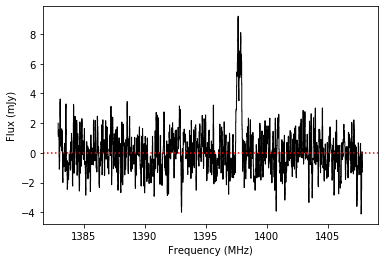

In [88]:
fig, axs = plt.subplots(figsize=(6,4))
axs.plot(data['FREQUENCY'],data['FLUX'],ds='steps-pre', c='k', alpha=1., lw=1.)
axs.axhline(0.,ls=':',c='r')
axs.set_ylabel('Flux (mJy)')
axs.set_xlabel('Frequency (MHz)')
#axs.set_xlim(3000,7000)
plt.show()

In [84]:
freq = np.array(data['FREQUENCY'])*u.MHz
flux = np.array(data['FLUX'])*u.mJy
spec = Spectrum1D(spectral_axis=freq,flux=flux+1.*u.mJy,velocity_convention="optical",rest_value=1420.405752*u.MHz)
#flux

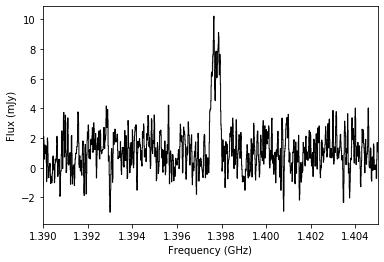

In [101]:
f, ax = plt.subplots()
ax.step(spec.frequency, spec.flux,c='k',lw=1.)
#ax.step(data['VHELIO'],data['FLUX'],alpha=0.25,c='r')
ax.set_ylabel('Flux (mJy)')
ax.set_xlabel('Frequency (GHz)')
#ax.set_xlabel('Velocity (km s$^{-1}$)')
ax.set_xlim(1.39,1.405)
plt.show()

In [103]:
equivalent_width(spec, regions=SpectralRegion(1.396*u.GHz, 1.40*u.GHz))

<Quantity -2.39604705 MHz>

In [104]:
equivalent_width?